# Star Identification Notebook

By this point, we've uploaded our images to astrometry and figured out where they actually are. With that, we could look up in proper catalogues what each of the stars are and their names and such, but that's a bit more than we need. For our analysis, we care about one star, the one with the exoplanet, but other than that, the other ones aren't all that important. It is helpful to have some way to identify and distinguish between them, even if their proper designations are excessive. 

Additionally, in order for our code to look at stars, it'll need to know where the stars are. What this notebook will do is scan through our images, and identify the bright areas, follow some specific filtering steps we'll tell it to do, and then save the locations of those stars (we'll start with x and y pixel locations, and convert them to RA/DEC so we can use them for all our images), along with new arbitrary names for the stars to a text file that can then be used to really dig into the analysis and processing.

-----
The first step, as with all of the new sub notebooks, is to tell python about where to find our special QAOP resources.

In [8]:
import sys
#My QAOP folder is in: /Users/aidanmcclung/Desktop/Summer_Exoplanets

codeFilePath = '/Users/aidanmcclung/Desktop/Summer_Exoplanets/'  #/QAOP/ <- folder containing QAOP folder.
sys.path.append(codeFilePath) #this lets python know to look here for import statements

In [9]:
#we also will want to know where our data and images are
from QAOP.QAOP_utils import readConfigFile
extraCodeFilePath,dataFilePath,errormsg = readConfigFile(configPath=codeFilePath+'QAOP/')
print(extraCodeFilePath,dataFilePath,errormsg)

/Users/aidanmcclung/Desktop/Summer_Exoplanets/ /Users/aidanmcclung/Desktop/Summer_Exoplanets/T18Test/Data/ no errors


-----

Next, I should do a bit of an explanation of how this will work, because it starts to get a bit funky.

Because it can be pretty irrelevant and complicated how some things are done, I've hidden away some code in the `QAOP_StarID` module. However, part of the goal of doing the analysis in python is for you students to really understand whats going on, and so hiding away those bits kind of defeats the purpose. 

As a solution, I try to go through and teach and build up everything we're doing so you understand. The guts of it is still in the module, and we'll do things once or so, and then have it hidden away for the rest of them, but hopefully that is a good middle ground between showing but not overcomplicating.

-----

## Looking at images

The first thing we should probably learn is how to look at images with python, since, for all of our analysis we've done, we haven't yet done so in python.

It is surprisingly easy to do. You need the special fits package to read in the files, but from there, we just have a glorifed numpy array, and we can do a simple call to `matplotlib.pyplot` to display the image.

The image itself can be worked with like any numpy array; you can add, or subtract, or divide, etc. You can take slices of it like we do in python, and many more things that we have no need to get into.

In [10]:
from astropy.io import fits #understand fits file format
import numpy as np
import matplotlib.pyplot as plt

Next we'll need to actually load and read in a file. We've technically done this already if you did the before and after comparison in the astrometry notebook, but if you skipped that, the following is the general pattern for loading in a file.

We make sure to always use `with` and then have everything tabbed over, because that way python takes care of the memory (RAM) management for us in an optimal way, and we don't forget to close files when we're done with them.

FITS files contain two major parts; a header, and the data. To further clarify notation, these are stored in Header Data Units. You can have as many of those as you want in a fits file, so when we read in a file we have a List of Header Data Units - that's what we call `hdul`. Our images our just one image, so we only deal with the zero-th element in this list.

The header is like a list of a whole bunch of information about the image that could be useful, and is also where the location information we created lives. We specifically take out the time the image was taken in the following cell, but there are many more things to see with `print(repr(header))` if you're curious whats in there.

The data is the image itself. Our image is only a single colour (ie, black and white), so it's just a 2D array, where each element is the brightness/intensity that pixel should be.

You can actually plot any numpy array using `plt.imshow` (image show), since all images are actually arrays, though more complicated ones with colors may have vectors at each element for how much of each color is there, rather than the scalars we have.

This image was taken at 2023-08-21T20:45:38.620 (UTC)
This image is (3194, 4788) pixels


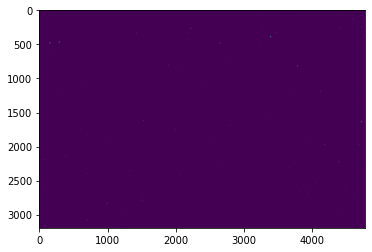

In [11]:
imagefilepath = dataFilePath + 'output/001.fits' #I've made the assumption you did the astrometry, and have at least one image.
#You can absolutely change what image you use though, and should if there's anything suboptimal about your image.

with fits.open(imagefilepath) as hdul:
    image = hdul[0].data #firstly, we need to extract our image!
    image_datetime = hdul[0].header['date-obs']
    print(f'This image was taken at {image_datetime} (UTC)')
    print(f'This image is {image.shape} pixels') #np.shape returns the dimensions of an array
    
    plt.imshow(image)
    plt.show()

That's the absolute basics. Chances are, your image that just showed up isn't particularly good or interesting, and that's because the default parameters aren't all that optimal, and there's some tweaking to do.

Now is a good time to introduce a few of the plotting settings that I myself use, and you should probably use as well, though maybe with some modifications as necessary.

The first is that we'll be using `plt.figure` to make our image a bit bigger and better. This method actually redirects to `plt.subplots` with only a single subplot, so you could just as easily use that, and we may do that in the future.

The second, and perhaps the most significant chagne will be rescaling the colours in the image; it is, by default, using the Viridis color map, and it's not scaled very well to show us things. We're much more interested in seeing the 'bigger picture' (parden my pun), and we (probably) want to use a logarithmic scale instead. We can also change to colors to be a bit more starlike, or, anything you want really!

We'll also stick on a bar showing what the colours actually mean, and we might as well add a title to calrify as well.

As a final very important tidbit: even though we defined and created `image` inside of the `with` block, they exist outside of it, so we can go back to them whenever we want!

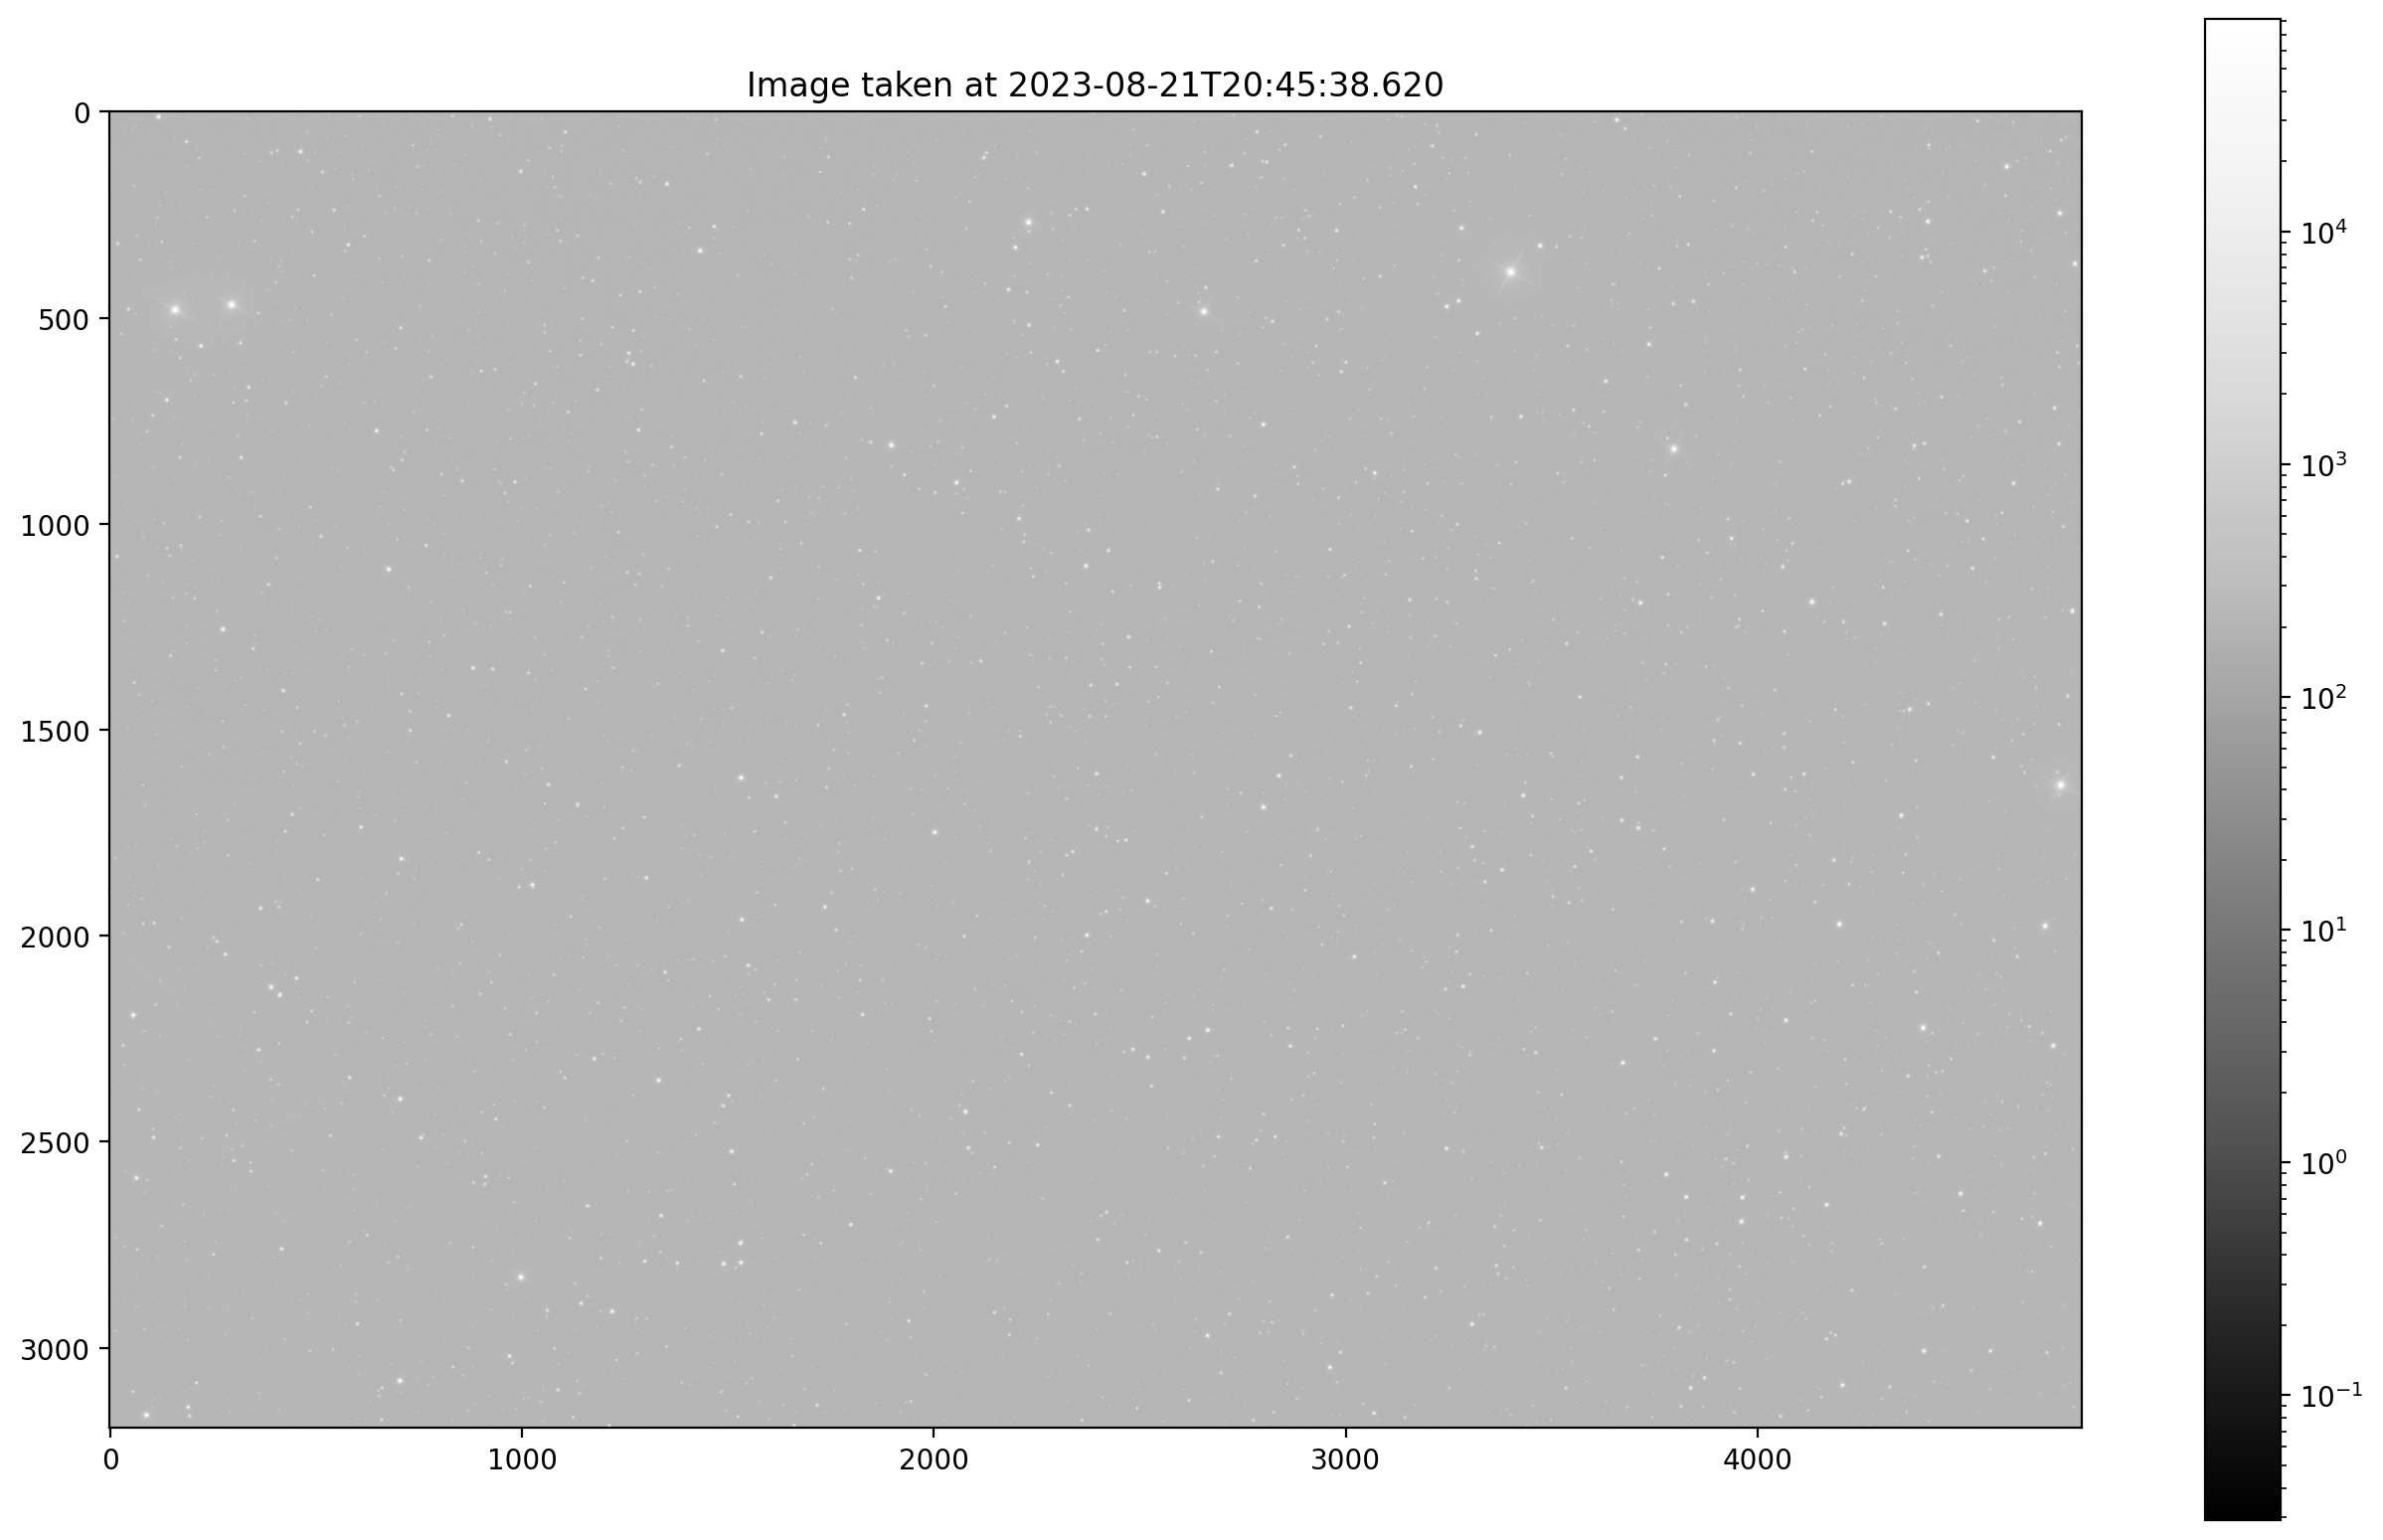

In [12]:
plt.figure(figsize=(16,10),dpi=200) #make the plot big and very HD! 
#16 by 10 is my laptops aspect ratio, you might need to change it if it doesnt fit on your screen
plt.imshow(image, norm='log',cmap='Greys_r')
plt.colorbar()
plt.title(f"Image taken at {image_datetime}")
plt.show()

To get one final thing out of the way that may or may not be useful, there are also methods built in to show the location of the image. I figured I should probably demonstrate how to do that, although I don't personally use it much. This will be the first thing we'll need the World Coordinate System information for!

In [6]:
from astropy.wcs import WCS # how we use our location information

import warnings; warnings.filterwarnings('ignore') #it will complain that iTelescopes format is outdated, we don't care

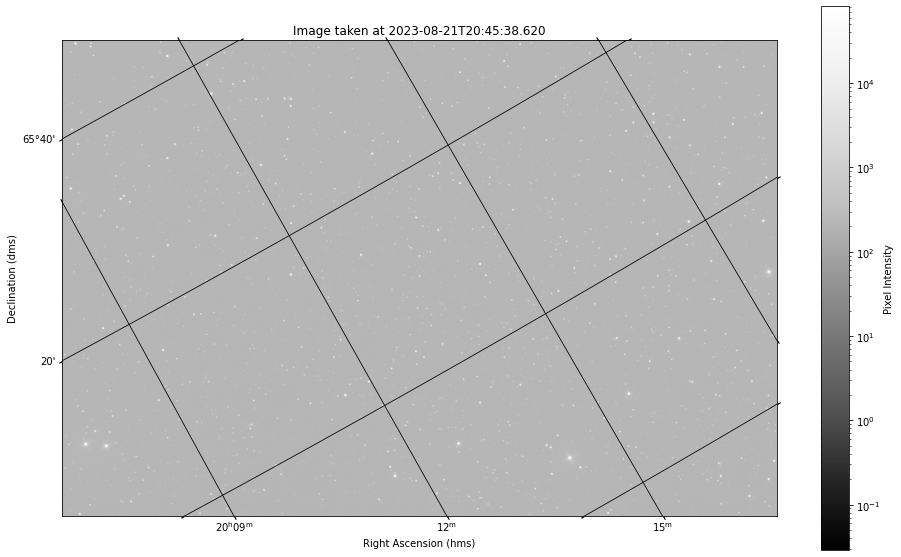

In [7]:
with fits.open(imagefilepath) as hdul:
    image_wcs = WCS(hdul[0].header) #read in the WCS info in the header, if any
    
plt.figure(figsize=(16,10)) #make the plot bigger
plt.subplot(projection=image_wcs) #tell matplotlib about our RA/DEC scale
#16 by 10 is my laptops aspect ratio, you might need to change it if it doesnt fit on your screen
plt.imshow(image, norm='log', cmap='Greys_r', origin='lower') #our image was also kind of upside down before...
plt.grid(color='black') #show our fancy gridlines!
plt.colorbar(label='Pixel Intensity')
plt.title(f"Image taken at {image_datetime}")
plt.ylabel("Declination (dms)")
plt.xlabel("Right Ascension (hms)")
plt.show()

## Finding the stars

That's enough plotting for now. The next thing we need to do is find where all the stars in our image are. We'll do this by using a peak finding algorithim; essentially an optimized version of "for every pixel, look at it's neighbors, and, if it's higher than all of them, it's a peak"

However, we need some way to decide what is 'a star' and what is 'not a star', since, if the image has random background noise (like TV static), there will be peaks that show up randomly in the noise. The answer to this is that we'll look at every pixel in the whole image, and calculate the median, and the standard deviation. These two values pretty well characterize the background noise in the image, and we can then only consider peaks that are some number of standard deviations higher than the mean as being possible stars that we might use for our analysis.

In [ ]:
from astropy.stats import sigma_clipped_stats # how we get the mean, median, and std of an image
from photutils.detection import find_peaks #the peak finding algorithm we'll use. Scipy also has a version we could use

In [ ]:
#first we want to get the noise characterization
mean, median, std = sigma_clipped_stats(image, sigma=3.0) #idk why sigma is 3... it does the same if you don't say that
#every example I could find specified the sigma=3 though, so we will too unless corrected otherwise.
print(f'Mean: {mean}, Median:{median}, Standard Deviation: {std}')

In [ ]:
#now we'll need to set some threshold. It's very unlikely that anything that 
#  peaks more than 5 sigma from the median isn't a star
possible_star_threshold = median + (5.0 * std)
print(f'In order to maybe be a star, a peak should be at least {possible_star_threshold} (pixel brightness units) high.')

#Another parameter we can specify is how close things can be and still be considered seperate peaks. 
#If two sources are within like 5 pixels of each, we wouldn't be able to resolve them anyway, 
#   so we might as well just call them the same source.
# We specify this with a box that is 11 pixels big: 5 pixels on each side plus the one in middle
minimum_star_spacing = 11.0
print(f'In order to maybe be a star, a peak should also be at least {(minimum_star_spacing-1)/2} pixels from any other peaks.') 

In [ ]:
#now we can actually find those peaks!
image_peaks = find_peaks(image, threshold=possible_star_threshold, box_size = minimum_star_spacing)


-----
### Brief Tangent: Astropy Tables

In many instances we will encounter a new type of python object; the astropy `Table`. This is, as it is named, a data table format. It has, like any table, rows and columns. The columns have names, but the rows are just numbered. This makes it, in a way, kind of like a list of dictionaries, although it is much more accessible than that would be.

There are many methods and things you can do with `tables`, and we will be using them a lot as we do things. 

As an introduction to them: 
- you can access a column by calling the table with a dictionark style reference: `image_peaks['peak_value']`
- you can access a specific row by calling an index: `image_peaks[5]`
- you can add a row, which can either be a list (in the right order!) or a dictionary
- you can add a column (the same way you would add an item to a dictionary) `image_peaks['rating'] = [ratings list]
- you can take slices, both in row direction and column direction
- You can read and print Tables to files really easily!


-----

As you may have inferred from the examples in the tangent, `find_peaks` returns a data table with the results. This is actually one of the few differences between the `photutils` version and the `scipy` version, and why we use the one we do.

Now, lets look at the peaks we found:

In [ ]:
print(image_peaks)

In [ ]:
peak_values = image_peaks['peak_value'].data 
# taking the .data gets rid of the extra overhead of the column name, and gives us an np array
print(f'Taking the .data of a table column gives us a: {type(peak_values)}')
print(f"Otherwise we'd have a: {type(image_peaks['peak_value'])}")

print("Those peaks are, specifically:",peak_values)

# We could again take things like the mean, median, std, min, max, etc of the peak values
peak_mean = np.mean(peak_values)
print(f"The mean peak value is {peak_mean}")
peak_median = np.median(peak_values)
print(f"The median peak value is {peak_median}")

#print(np.max(peak_values))

-----
That's all pretty interesting.

As we saw in the number of rows that our peak table had, there are an awful lot of stars. (I had 8249 peaks)

However, we should also notice how far apart the mean and median peak values are; that means that the vast majority of our peaks are very low, which is actually good because having to utilize thousands of stars would not be a great time for us...

In order to proceed, the next step will be to filter down all those peaks, which we'll do based on a couple criteria.

One of the more important ones, is that we want stars that have a similar peak brightness to our target star when we're doing our differential photometry, because they'll have been affected in a similar way.

We should also prefer stars that are more towards the center of the image, since there may be some residual variations that make the edges different. (Part of the calibration process done automatically by iTelescope should take care of those variations, but it's not always perfect)

We should absolutely make sure we don't use stars that are oversaturated. We do this by ditching any star that peaks higher than a certain 'danger point' that we define; usually a bit less 60k, but it's not super fixed.

And, as a final criteria, we'll want to only take so many of the best stars; that will come later though.

In [ ]:
#first, we need to know our target's peak. This should be something you found manually before the astrometry step 
#if you didnt do that then, do it now. 
target_star_peak = 30000 #it is probably not 30k, but I had to put something

#it would probably be useful to know how far each peak is from our target peak, which we'll do by taking the difference
# and then taking the absolute value
diff_from_target_peak = image_peaks['peak_value'].data - target_star_peak
#we could also make a np.full(len(image_peaks),target_star_peak) if we wanted to be sure it did array math right
delta_from_target_peak = np.abs(diff_from_target_peak)


#the following were me experimenting, we come back to this later, but it's kind of too early...

#print(delta_from_target_peak)
#print("The peak-delta standard deviation is:",np.std(delta_from_target_peak))

plt.hist(delta_from_target_peak)
plt.title("How far from target star's peak value our stars are.")
plt.show()

As we had identified, the vast majority of the stars are very dim, and approxtimately (the target brightness) away from the target brightness. We obviously don't want to use stars that are that different from the target, so we'll be able to cut down a lot.

As an inital baseline, lets just cut out any star that's less than several thousand, and we'll also at this time make note of those stars that are too close to being oversaturated

In [ ]:
minimum_peak_threshold = 10000
maximum_peak_threshold = 50000 #oversaturation danger zone

indexes_below_min = np.where(peak_values < minimum_peak_threshold)[0] #np.where returns a list, but we don't care about anything other than the first element
#we could also take the inverse of that by getting all the numbers that weren't there, or we can get:
indexes_above_min = np.where(peak_values >= minimum_peak_threshold)[0]

#We can do the exact same thing for the upper side:
indexes_above_max = np.where(peak_values > maximum_peak_threshold)[0]
#or again with the inverse:
indexes_below_max = np.where(peak_values <= maximum_peak_threshold)[0]

#now, we can either:
# - cut out those rows that are too low, and then those that are too high 
# - cut out those that are both too low and those that are too high (set union)
# - Take the intersection between those that are high enough, and those that are low enough
# - Take those that are high, but not too high (set difference)
# - Take those that are low, but not too low (set difference)

#you could pick your poison however you want, but personally, I was a fan of the 'high but not too high' approach

where_peak_is_high = indexes_above_min
where_peak_is_too_high = indexes_above_max
where_peak_is_good = np.setdiff1d(where_peak_is_high,where_peak_is_too_high)
print(f"There are {len(where_peak_is_good)} stars with peaks between {minimum_peak_threshold} and {maximum_peak_threshold}")

Now, chances are, since we've now cut our star choices down, we don't care about the others very much. 

Rather than throwing them away though, we'll just create a new table that only has those ones we identified as being good candidates.

We will need to import the `Table` module in order to make our own, but we can start by taking the rows we want from the old table.

In [ ]:
new_table_rows = np.take(image_peaks,where_peak_is_good) #Tables are "arraylike" so you can use numpy methods on them.
#print(new_table_rows)

In [ ]:
from astropy.table import Table

In [ ]:
column_names = image_peaks.colnames

image_stars = Table(names=column_names,rows=new_table_rows)
print(image_stars)

It would probably be easier to calculate how far each of these peaks is from the target again, but we did techically already calculate that. 

I want to calculate that and add it as a column to demonstrate how before we get too far from the `Table` introduction, but it would make sense to do ALL of our cuts before we calculate that.

I will also show here a very helpful method. As you can see, by default the number of rows is capped, and it only shows so many, just like when printing arrays. However, there's a very convienient integration with Jupyter, that will display the whole thing, and you can scroll through as you wish.

In [ ]:
subset_delta_from_target = np.take(delta_from_target_peak, where_peak_is_good)
image_stars['delta_from_target'] = subset_delta_from_target

image_stars.show_in_notebook()

----

Now, I want to mention here that you can sort columns in a table, but I really should take care of that pesky 4th criteria I had mentioned; proximity to the edge.

We'll just do a quick pass through and see if any of the stars we have are close to the edge; how close is a very arbitrary thing, and it partially depends on how many we can get rid of...

In [ ]:
high_y, high_x = np.shape(image) #note that coordinates are [y,x] not [x,y]!
# we know that because the image is wider than it is tall, so the large number must be our width
print(high_y,high_x)
# we can also look at our peak table; in mine, I have a max y of 3194, and I can see the bottom rows have y values of approxtimately that.
#further, I can see that some of the x are above 3194 to confirm my selection.

x_buffer = 0.1 * high_x #we'll ditch the outer 10%
y_buffer = 0.1 * high_y
print(x_buffer, y_buffer)
#for simplicity, I'll redefine as whole numbers close to those values:
x_buffer = 480
y_buffer = 320

#now we want to filter the table; we'll do this exactly like we did before
x_too_low = np.where(image_stars['x_peak'] <= (0 + x_buffer))
x_too_high = np.where(image_stars['x_peak'] >= (high_x - x_buffer))

y_too_low = np.where(image_stars['y_peak'] <= (0 + y_buffer))
y_too_high = np.where(image_stars['y_peak'] >= (high_y - y_buffer))

#and we'll cut out all of those stars that are any of those

x_too_close_to_edge = np.union1d(x_too_low,x_too_high)
y_too_close_to_edge = np.union1d(y_too_low,y_too_high)
indexes_too_close_to_edge = np.union1d(x_too_close_to_edge,y_too_close_to_edge)
print(indexes_too_close_to_edge)
#Due to how find_peaks is implemented, the table is actually ordered based on y_peak, so the two ends of the table will be cut

print()
print("The sub table that we'll be cutting is:")
print(image_stars[indexes_too_close_to_edge])

In [ ]:
#unlike last time, where we had the indexes we wanted to keep, we've now got the indexes to get rid of.
# (I wanted to demonstrate both)
#It's a bit trickier; instead of saying "hey I want these ones" we've now got to do the opposite.
#We can actually do just that; take the opposite
#And by that I mean, create an array of True, and then make the ones we don't want False

edge_bool_array = np.ones(len(image_stars),dtype=bool)
edge_bool_array[indexes_too_close_to_edge] = False
#print(edge_bool_array) #troubleshooting

#so now we can use that to 'mask' our table
print(image_stars[edge_bool_array])

In [ ]:
stars_to_choose_from = image_stars[edge_bool_array]

Now, finally, we get to the exciting bit; we will sort the table based on how far the peak is from the target peak, and then choose our top # of those, which we will name with a pattern and then save! Or well, kind of... Before we finish saving we'll have to convert our pixel coordinates into RA and DEC

In [ ]:
stars_to_choose_from.sort('delta_from_target')
#print(stars_to_choose_from)

number_of_stars_to_keep = 40


star_choices = stars_to_choose_from[:number_of_stars_to_keep]
star_choices.show_in_notebook()

Now, to name the stars!

This is an instance of me hiding some pretty messy code in the module. Basically, theres a thing `autonamer` to which you can give it a format (which is meant to be a simple single digit data type), and then it will count up and give you names, either by counting with its `nextName` method, or by giving it the name index with `name(nameInt)`.

There are two basic choices for name formats; Characters or Integers.
ie, you can have sA sB sC etc, or s1 s2 s3 etc

These are both implemented through two wrapper classes; `charnamer` and `intnamer`

In [ ]:
from QAOP.QAOP_starID import charnamer,intnamer
# Take your pick of the name formatting:
namer = charnamer()
#namer = intnamer()

star_names = []
for i in range(len(star_choices)):
    star_names.append(namer.nextName())
#print(star_names)

#and then we add the names to our table

star_choices['names'] = star_names

print(star_choices)

Now, it could be very useful for us to have this table saved for if we ever need it, even if it is in pixel coordinates, since it has useful information in it.

In [ ]:
star_choices.write(dataFilePath+'starIDs.ecsv',overwrite=True)

## Converting Pixels to Coordinates

The final thing we'll do here is convert the pixel coordinates we have into RA and DEC, and save that as the `nameloc.csv` we need to go back to the master notebook.

To do this, we'll need the wcs package we had before, but also some things to help with them that I want to introduce.
The first is `SkyCoord`inates. This is a special class that will store RA and DEC, and can be given parameters in basically any way you can think of and still get it right.
However, we will be using them a bit differently. contained in the `WCS` object, there are `pixel_to_world` and `world_to_pixel` methods, which take the coordinate they're going to convert, and then return the result.

In [ ]:
from astropy.coordinates import SkyCoord
#from astropy.wcs.utils import pixel_to_world, world_to_pixel

In [ ]:
#Recall that we had created a image_wcs object before; it should still be kicking around in the background
image_wcs.pixel_to_world(500,1000)

In [ ]:
#SkyCoord has a transform_to method if we wanted a different frame, like ICRS
image_wcs.pixel_to_world(500,1000).transform_to('icrs')

In [ ]:
#SkyCoord also has a to_pixel method, if we give it a wcs object, which does make this very convoluted
# However, it does help demonstrate that these SkyCoord and WCS objects know what framet they're in, and use that
image_wcs.pixel_to_world(500,1000).transform_to('icrs').to_pixel(image_wcs)

In [ ]:
#we can also get just the specific parameters from a skycoord
print("RA:",image_wcs.pixel_to_world(500,1000).ra)
print("DEC:",image_wcs.pixel_to_world(500,1000).dec)
print("String version:",image_wcs.pixel_to_world(500,1000).to_string(decimal=True))

----
In order to make our final desired table, we'll need to find an RA and DEC for each star, which we can do just like above

*As a minor sidenote: there is a performance difference from taking a column then row vs row then column for a table. Choosing a row first creates a new table with a single row in it, which is a bit of extra work*

In [ ]:
firstStar_x = star_choices['x_peak'][0] #better than star_choices[0]['x_peak']
firstStar_y = star_choices['y_peak'][0]

firstStar_sc = image_wcs.pixel_to_world(firstStar_x,firstStar_y) #sc for SkyCoord
firstStar_ra = firstStar_sc.ra
firstStar_dec = firstStar_sc.dec

firstStar_name = star_choices['names'][0]

#and then, we would add it in the format we need for the nameloc file: Name,RA,DEC
firstStar_nameloc = {'Name':firstStar_name,'RA':firstStar_ra.value,'DEC':firstStar_dec.value}
#note the use of the ".value" for the ra nad dec, other wise it has all this angle unit stuff on it, which is meh
print(firstStar_nameloc)

To really do this, we'll loop through all the stars we chose. 
However, before we do that, we'll create a `nameLocTab` which will be the table we save the results to.

*there is another table based performance gain thing to mention; idk why, but if you're adding rows via a loop, it's actually a lot faster to create a list, append the rows to it, and then call `add_row` with the list...*

In [ ]:
nameLocTab = Table(names=['Name','RA','DEC'],dtype=[str,float,float])

In [ ]:
def convertChoiceToNameLoc(index,choices=star_choices,image_wcs=image_wcs):
    x = choices['x_peak'][index]
    y = choices['y_peak'][index]
    name = choices['names'][index]
    sc = image_wcs.pixel_to_world(x,y)
    ra = sc.ra.value
    dec = sc.dec.value
    return {'Name':name,'RA':ra,'DEC':dec}

rows_to_add = []
for index in range(len(star_choices)):
    rows_to_add.append(convertChoiceToNameLoc(index))
#nameLocTab.add_row([rows_to_add])
#I made some mistake, anyway, we'll call Table with a rows parameter:
nameLocTab = Table(rows=rows_to_add,names=['Name','RA','DEC'],dtype=[str,float,float])
print(nameLocTab)

In [ ]:
#and now, we need to add our target star's location before we export it.
from QAOP.QAOP_utils import hmsToDeg,dmsToDeg

# YOU NEED TO CHANGE THIS TO BE YOUR STARS LOCATION
target_RA = hmsToDeg(20,13,31.65)
target_DEC = dmsToDeg(65,9,44.39)

nameLocTab.add_row({'Name':'target','RA':target_RA,'DEC':target_DEC})

In [ ]:
#finally, we save it.
nameLocTab.write(dataFilePath+'nameloc.csv',overwrite=True)

You have now completed this phase! You may return to the master notebook with your newly named stars